In [11]:
import torch

import torch.nn as nn
import os
import shutil
import itertools
import random

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from jmlr_2018_code.datasets import Mpeg7
from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 600
    lr_initial = 0.1
    momentum = 0.9
    lr_epoch_step = 200
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
mpeg7_data_set = Mpeg7(root_dir='./data')
mpeg7_data_set.sample_transforms = [
                                    lambda x: {k: x[k] for k in used_directions}, 
                                    numpy_to_torch_cascade,
                                    lambda x: collection_cascade(x, 
                                                                 lambda x: isinstance(x, torch._TensorBase), 
                                                                 lambda x: coordinate_transform(x))
                                   ]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found data!


In [12]:
class PHTCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y                       
    
collate_fn_train = PHTCollate(train_env.nu, cuda=True)
collate_fn_test = PHTCollate(train_env.nu, cuda=True)

In [3]:
train_sampler, test_sampler = get_train_test_sampler(mpeg7_data_set, train_env.train_size, stratified=True)

dl_train = DataLoader(mpeg7_data_set,
                      batch_size=train_env.batch_size, 
                      collate_fn=collate_fn_train,
                      sampler=train_sampler)

dl_test = DataLoader(mpeg7_data_set,
                     batch_size=train_env.batch_size, 
                     collate_fn=collate_fn_test, 
                     sampler=test_sampler)

Generated training and testing split:
Train: Counter({5: 18, 0: 18, 43: 18, 12: 18, 23: 18, 36: 18, 38: 18, 42: 18, 7: 18, 26: 18, 10: 18, 35: 18, 44: 18, 54: 18, 19: 18, 52: 18, 18: 18, 6: 18, 47: 18, 61: 18, 69: 18, 32: 18, 16: 18, 30: 18, 48: 18, 37: 18, 28: 18, 58: 18, 21: 18, 50: 18, 3: 18, 22: 18, 20: 18, 2: 18, 63: 18, 59: 18, 14: 18, 53: 18, 25: 18, 39: 18, 24: 18, 8: 18, 65: 18, 45: 18, 68: 18, 60: 18, 41: 18, 49: 18, 66: 18, 64: 18, 29: 18, 13: 18, 1: 18, 46: 18, 27: 18, 56: 18, 17: 18, 40: 18, 31: 18, 57: 18, 15: 18, 62: 18, 33: 18, 55: 18, 51: 18, 34: 18, 67: 18, 11: 18, 9: 18, 4: 18})
Test: Counter({39: 2, 11: 2, 34: 2, 48: 2, 46: 2, 29: 2, 30: 2, 53: 2, 0: 2, 10: 2, 20: 2, 57: 2, 68: 2, 38: 2, 40: 2, 69: 2, 61: 2, 60: 2, 31: 2, 26: 2, 33: 2, 50: 2, 12: 2, 47: 2, 41: 2, 27: 2, 37: 2, 28: 2, 67: 2, 36: 2, 52: 2, 5: 2, 49: 2, 17: 2, 22: 2, 35: 2, 44: 2, 14: 2, 59: 2, 4: 2, 62: 2, 13: 2, 18: 2, 56: 2, 55: 2, 24: 2, 45: 2, 43: 2, 19: 2, 6: 2, 9: 2, 1: 2, 58: 2, 23: 2, 16: 2, 2

In [13]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=0.1)
#     return SLayerRational(n_elements=n_elements, 
#                           point_dimension=2, 
#                           sharpness_init=25, 
#                           exponent_init=1, 
#                           share_sharpness=False,
#                           share_exponent=False,
#                           pointwise_activation_threshold=None,
#                           freeze_exponent=False
#                           )

#     return SLayerExponential(n_elements=n_elements, point_dimension=2)


def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ELU(),
#                       nn.LeakyReLU()
                     )
    m.out_features = m[0].out_features
    return m


class Mpeg7_model(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 150
        
        self.reccurent_in_dim = self.n_elements #int(self.n_elements/2)
        self.reccurent_out_dim = self.n_elements #int(self.n_elements/2)
        self.batch_size = train_env.batch_size
        
        self.slayers = ModuleDict()
#         self.slayers_2_recurrent_linears = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = s            
#             l = nn.Linear(s.n_elements, self.reccurent_in_dim)
#             self.slayers_2_recurrent_linears[k] = LinearCell(self.n_elements, self.reccurent_in_dim)
            
        self.recurrent = nn.LSTM(self.reccurent_in_dim, self.reccurent_out_dim)
        
        n_1 =150
        self.cls = nn.Sequential(
                                 nn.Dropout(0.3),
                                 nn.BatchNorm1d(self.reccurent_out_dim),
                                 LinearCell(self.reccurent_out_dim, n_1),
                                 nn.Dropout(0.2),
                                 LinearCell(n_1, int(n_1/2)),
                                 nn.Dropout(0.1),
                                 nn.Linear(int(n_1/2), 70)
                                )
        
    def forward(self, input):
        x = []
        for k in used_directions:            
            xx = self.slayers[k](input[k])
#             xx = self.slayers_2_recurrent_linears[k](xx)
            x.append(xx)

        x = torch.stack(x, dim=0)  
        x = torch.cat([x]*10, dim=0)
        
        x, _ = self.recurrent(x)
        
        x = x[-1]
        x = x.squeeze()
        
        x = self.cls(x)        
               
        return x
    
    def parameters_split(self):
        return {'non_linear': self.slayers.parameters(),
                'linear': itertools.chain(self.cls.parameters(), self.recurrent.parameters())}
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k].centers.data = v
            
            

In [14]:
model = Mpeg7_model()
model.center_init([mpeg7_data_set[i] for i in train_sampler])
model.cuda()

stats = defaultdict(list)
opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

for i_epoch in range(1, train_env.n_epochs+1):      
    
    model.train()
        
    epoch_loss = 0    
    
    if i_epoch % train_env.lr_epoch_step == 0:
        adapt_lr(opt, lambda lr: lr*0.5)
    
    for i_batch, (x, y) in enumerate(dl_train, 1):              
        
        y = torch.autograd.Variable(y)
        
        def closure():
            opt.zero_grad()
            y_hat = model(x)            
            loss = nn.functional.cross_entropy(y_hat, y)   
            loss.backward()
            
#             torch.nn.utils.clip_grad_norm(model.parameters_split()['non_linear'], 1, norm_type='inf')
            return loss

        loss = opt.step(closure)
        
        epoch_loss += float(loss)
        stats['loss_by_batch'].append(float(loss))
        stats['centers'].append(model.slayers['dim_0_dir_0'].centers.data.cpu().numpy())
        
        print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")
  
    stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))
        
    print("\n\r testing...")
    model.eval()    
    true_samples = 0
    seen_samples = 0
    epoch_test_loss = 0
    for i_batch, (x, y) in enumerate(dl_test):

        y_hat = model(x)
        epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

        y_hat = y_hat.max(dim=1)[1].data.long()

        true_samples += (y_hat == y).sum()
        seen_samples += y.size(0)  
     
    stats['test_accuracy'].append(true_samples/seen_samples)
    stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
    print(true_samples/seen_samples)

Epoch 1/600, Batch 13/13       
 testing...
0.02142857142857143
Epoch 2/600, Batch 13/13       
 testing...
0.03571428571428571
Epoch 3/600, Batch 13/13       
 testing...
0.11428571428571428
Epoch 4/600, Batch 13/13       
 testing...
0.2571428571428571
Epoch 5/600, Batch 13/13       
 testing...
0.2357142857142857
Epoch 6/600, Batch 13/13       
 testing...
0.3
Epoch 7/600, Batch 13/13       
 testing...
0.37857142857142856
Epoch 8/600, Batch 13/13       
 testing...
0.37857142857142856
Epoch 9/600, Batch 13/13       
 testing...
0.42857142857142855
Epoch 10/600, Batch 13/13       
 testing...
0.3357142857142857
Epoch 11/600, Batch 13/13       
 testing...
0.32142857142857145
Epoch 12/600, Batch 13/13       
 testing...
0.5357142857142857
Epoch 13/600, Batch 13/13       
 testing...
0.4642857142857143
Epoch 14/600, Batch 13/13       
 testing...
0.4928571428571429
Epoch 15/600, Batch 13/13       
 testing...
0.5571428571428572
Epoch 16/600, Batch 13/13       
 testing...
0.5142857142

Epoch 131/600, Batch 13/13       
 testing...
0.8142857142857143
Epoch 132/600, Batch 13/13       
 testing...
0.8571428571428571
Epoch 133/600, Batch 13/13       
 testing...
0.8571428571428571
Epoch 134/600, Batch 13/13       
 testing...
0.7928571428571428
Epoch 135/600, Batch 13/13       
 testing...
0.8785714285714286
Epoch 136/600, Batch 13/13       
 testing...
0.8428571428571429
Epoch 137/600, Batch 13/13       
 testing...
0.8071428571428572
Epoch 138/600, Batch 13/13       
 testing...
0.8357142857142857
Epoch 139/600, Batch 13/13       
 testing...
0.8785714285714286
Epoch 140/600, Batch 13/13       
 testing...
0.8714285714285714
Epoch 141/600, Batch 13/13       
 testing...
0.8785714285714286
Epoch 142/600, Batch 13/13       
 testing...
0.85
Epoch 143/600, Batch 13/13       
 testing...
0.7857142857142857
Epoch 144/600, Batch 13/13       
 testing...
0.7928571428571428
Epoch 145/600, Batch 13/13       
 testing...
0.8428571428571429
Epoch 146/600, Batch 13/13       
 test

Epoch 264/600, Batch 13/13             
 testing...
0.8928571428571429
Epoch 265/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 266/600, Batch 13/13       
 testing...
0.9
Epoch 267/600, Batch 13/13       
 testing...
0.9
Epoch 268/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 269/600, Batch 13/13       
 testing...
0.9
Epoch 270/600, Batch 13/13       
 testing...
0.9
Epoch 271/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 272/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 273/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 274/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 275/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 276/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 277/600, Batch 13/13              
 testing...
0.9
Epoch 278/600, Batch 13/13       
 testing...
0.8928571428571429
Epoch 279/600, Batch 13/13       
 testing...
0.8928571428571429
Epoch 280/600, Batch 1

Epoch 400/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 401/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 402/600, Batch 13/13             
 testing...
0.9214285714285714
Epoch 403/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 404/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 405/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 406/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 407/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 408/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 409/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 410/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 411/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 412/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 413/600, Batch 13/13       
 testing...
0.9142857142857143
Epoch 414/600, Batch 13/13       
 testing...
0.9214285714285714
Epoch 415/600, Batc

Epoch 538/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 539/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 540/600, Batch 13/13       
 testing...
0.9
Epoch 541/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 542/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 543/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 544/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 545/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 546/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 547/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 548/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 549/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 550/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 551/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 552/600, Batch 13/13       
 testing...
0.9071428571428571
Epoch 553/600, Batch 13/13       
 testi

<IPython.core.display.Javascript object>


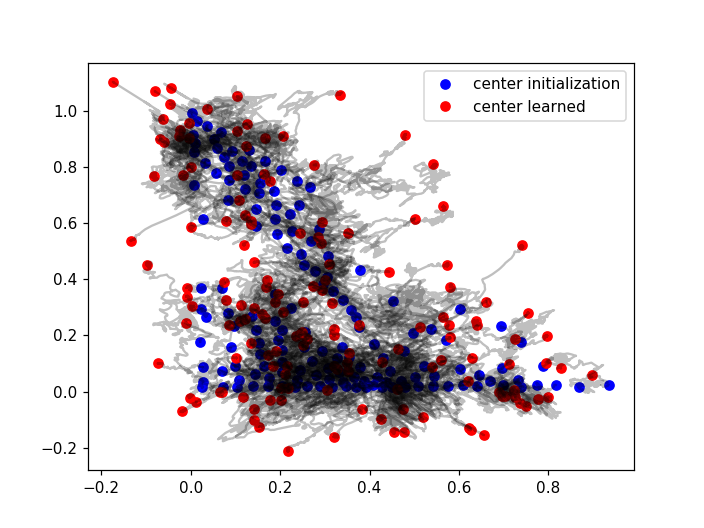

<IPython.core.display.Javascript object>


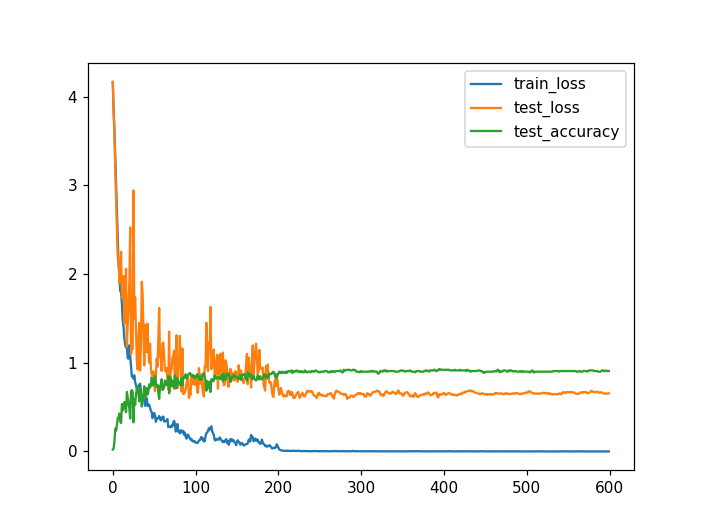

In [15]:
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()


In [10]:
stats['test_accuracy'][-20:]

[0.9,
 0.9071428571428571,
 0.9071428571428571,
 0.9071428571428571,
 0.9,
 0.9071428571428571,
 0.9071428571428571,
 0.9071428571428571,
 0.9,
 0.9,
 0.9,
 0.9071428571428571,
 0.9,
 0.8928571428571429,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9]

In [ ]:
model.slayers['dim_0_dir_0'].radius.min()